<a href="https://colab.research.google.com/github/RymMehdi/Rym/blob/master/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Final Project NLP**

# team members:
- Rym Mehdi
- Skander Ben Brik

In [106]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tensorflow import keras
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


Definition of a plot function for training result visualization

In [3]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

Importing the data

In [4]:
train_data = pd.read_csv('./train.txt', delimiter = ';', header = None)
train_data.columns = ['comments', 'feeling']
test_data = pd.read_csv('./test.txt', delimiter=';', header=None)
test_data.columns = ['comments', 'feeling']
train_data.head()

,comments,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  16000 non-null  object
 1   feeling   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [6]:
test_data.head()

,comments,feeling
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  2000 non-null   object
 1   feeling   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


## ***preprocessing data***


**tokenization**

In [8]:
# Separate features and labels
X_train = train_data['comments']
y_train = train_data['feeling']

X_test = test_data['comments']
y_test = test_data['feeling']

train_size = len(X_train)
test_size = len(X_test)
batch_size = 32

In [9]:
# Initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [10]:
# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_len)


In [11]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [12]:
# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_encoded))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_encoded))
test_dataset = test_dataset.batch(32)

In [28]:
num_classes = len(train_data['feeling'].unique())

#**Models**

### **1. A Fully Connected Neural Network**

In [74]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 50)            760650    
                                                                 
 flatten (Flatten)           (None, 3300)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               422528    
                                                                 
 dense_12 (Dense)            (None, 300)               38700     
                                                                 
 dense_13 (Dense)            (None, 6)                 1806      
                                                                 
Total params: 1,223,684
Trainable params: 1,223,684
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Compile the model
tf.keras.backend.clear_session()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [78]:

# Train the model
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset, callbacks=[early])

Epoch 1/30
500/500 [==============================] - 16s 30ms/step - loss: 1.2329 - accuracy: 0.5161 - val_loss: 0.6947 - val_accuracy: 0.7445
Epoch 2/30
500/500 [==============================] - 15s 30ms/step - loss: 0.3803 - accuracy: 0.8619 - val_loss: 0.5151 - val_accuracy: 0.8275
Epoch 3/30
500/500 [==============================] - 17s 35ms/step - loss: 0.1033 - accuracy: 0.9681 - val_loss: 0.6494 - val_accuracy: 0.8185
Epoch 4/30
500/500 [==============================] - 13s 25ms/step - loss: 0.0392 - accuracy: 0.9898 - val_loss: 0.7265 - val_accuracy: 0.8170
Epoch 5/30
500/500 [==============================] - 13s 25ms/step - loss: 0.0243 - accuracy: 0.9944 - val_loss: 0.7807 - val_accuracy: 0.8205
Epoch 6/30
500/500 [==============================] - 11s 22ms/step - loss: 0.0173 - accuracy: 0.9955 - val_loss: 0.8349 - val_accuracy: 0.8310
Epoch 7/30
500/500 [==============================] - 13s 26ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.8088 - val_accuracy:

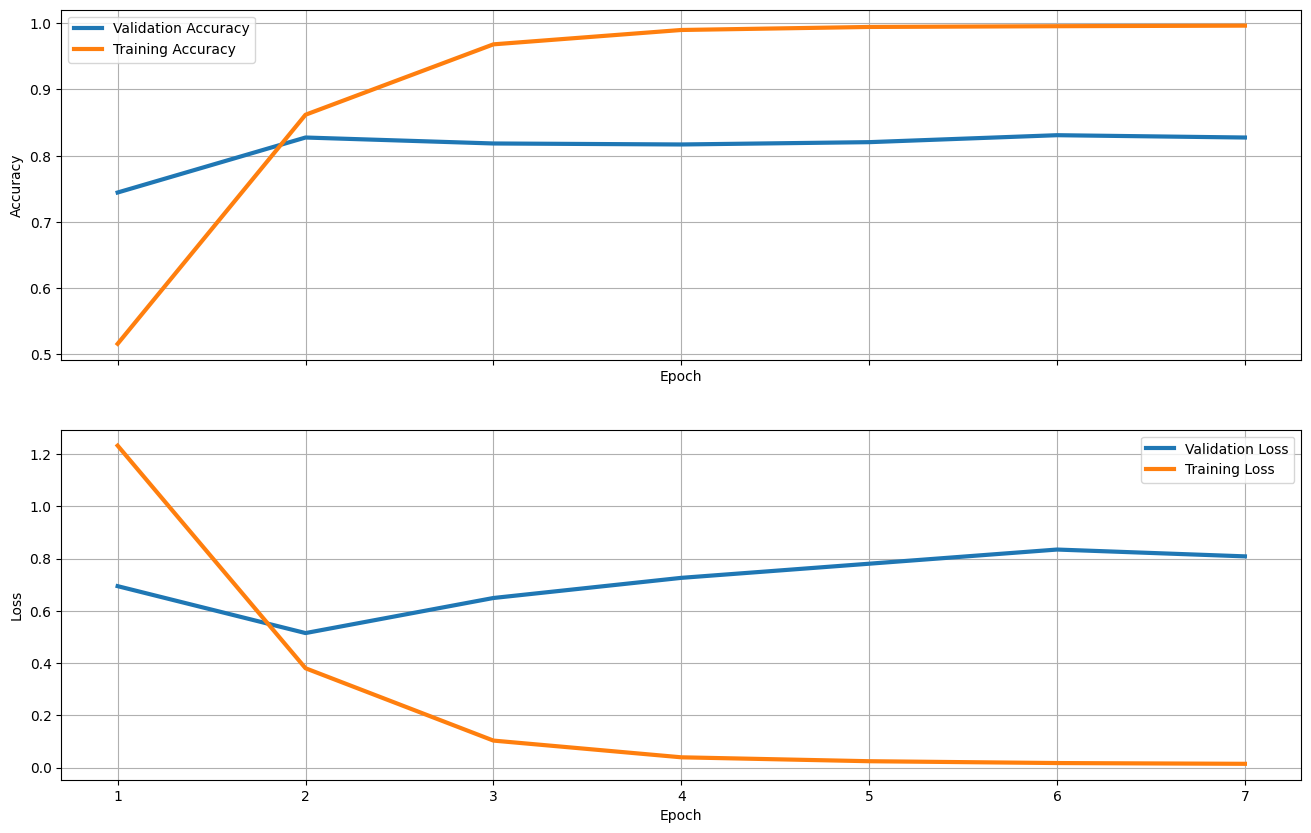

In [79]:
plot_results(history)

## **2. A Recurrent Neural Network, based on LSTM**

In [112]:
# Model definition with lstm
model_lstm = tf.keras.Sequential([
    Embedding(vocab_size, 100, input_length=max_len),
    Conv1D(128, 5, activation='leaky_relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(64)),
    Dense(64, activation='leaky_relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1521300   
                                                                 
 conv1d (Conv1D)             (None, 62, 128)           64128     
                                                                 
 batch_normalization (BatchN  (None, 62, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                        

In [113]:
tf.keras.backend.clear_session()

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_lstm.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train_padded, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_padded, y_test_encoded), callbacks=[early])


Epoch 1/30
500/500 [==============================] - 46s 81ms/step - loss: 1.2851 - accuracy: 0.5173 - val_loss: 0.8552 - val_accuracy: 0.7555
Epoch 2/30
500/500 [==============================] - 39s 77ms/step - loss: 0.4670 - accuracy: 0.8347 - val_loss: 0.6046 - val_accuracy: 0.7710
Epoch 3/30
500/500 [==============================] - 40s 80ms/step - loss: 0.2890 - accuracy: 0.9006 - val_loss: 0.6957 - val_accuracy: 0.7730
Epoch 4/30
500/500 [==============================] - 39s 79ms/step - loss: 0.2128 - accuracy: 0.9267 - val_loss: 0.9064 - val_accuracy: 0.7520
Epoch 5/30
500/500 [==============================] - 40s 79ms/step - loss: 0.1893 - accuracy: 0.9351 - val_loss: 0.8661 - val_accuracy: 0.7485
Epoch 6/30
500/500 [==============================] - 38s 76ms/step - loss: 0.1635 - accuracy: 0.9448 - val_loss: 0.8547 - val_accuracy: 0.7665
Epoch 7/30
500/500 [==============================] - 39s 78ms/step - loss: 0.1556 - accuracy: 0.9451 - val_loss: 0.8761 - val_accuracy:

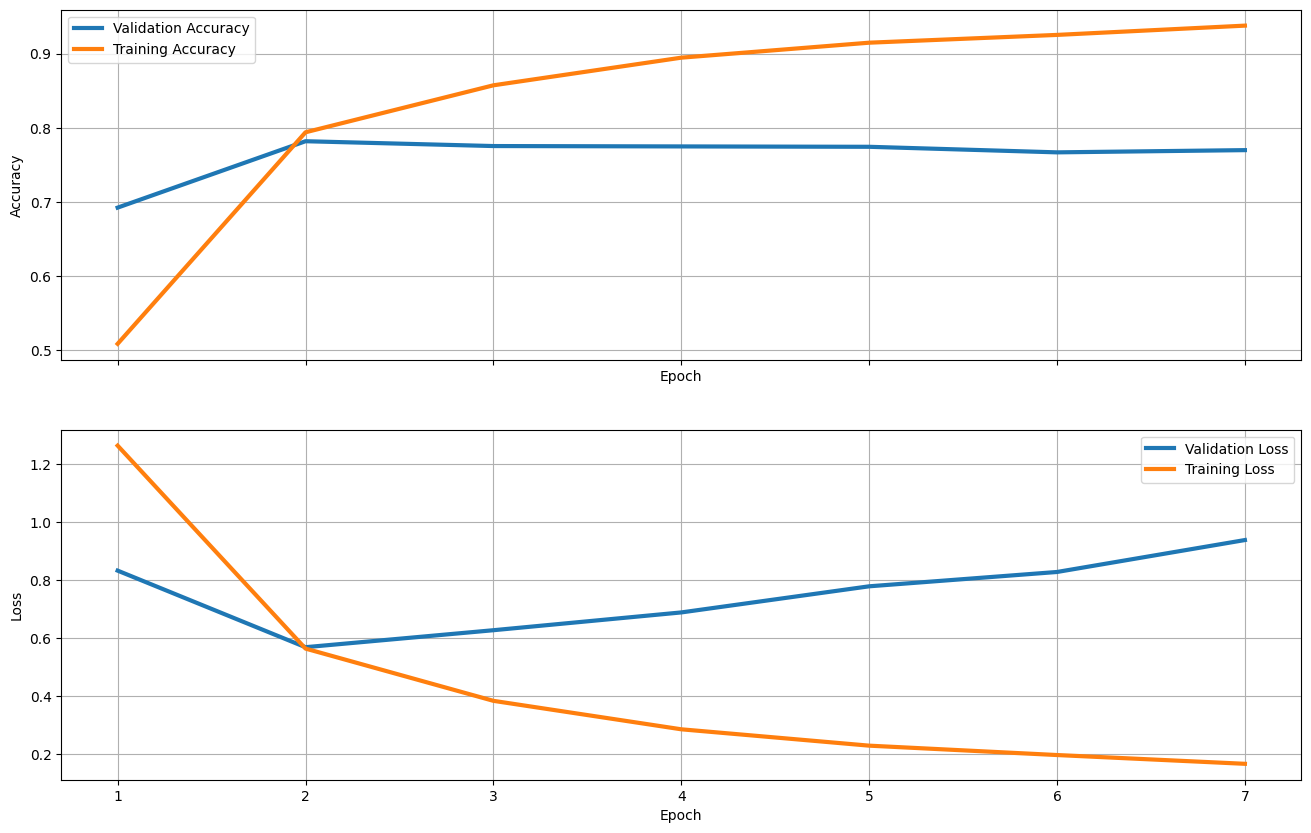

In [90]:
plot_results(history_lstm)

# **3/A fine-tuned Transformer Architecture from a pretrained model that can be found on sites HuggingFace**

In [99]:
pip install transformers tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00


In [68]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

In [69]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model_bert = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
X_train_list = X_train.tolist()
X_train_encodings = tokenizer(X_train_list, truncation=True, padding=True, max_length=max_len, return_tensors='tf')
y_train_labels_np = y_train_encoded
y_train_labels = tf.convert_to_tensor(y_train_labels_np)


In [71]:
# Custom model to handle attention_mask separately
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)

# Get the output from the BERT model base network
bert_output = model_bert(input_ids, attention_mask=attention_mask).logits


when i put bert_output = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state, il m'affiche votre session a planté après avois utiliser toute la mémoire RAM disponible.

( if i use bert_model = TFBertModel.from_pretrained(model_name) so that's why i only used model_bert = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes))

In [72]:
# Classification layer on top of BERT
classifier = tf.keras.layers.Dense(num_classes, activation='softmax')(bert_output)

# Create the final model
model_bert = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=classifier)

# Compile the model
model_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the classifier
num_epochs = 5
batch_size = 32
model_bert.fit([X_train_encodings['input_ids'], X_train_encodings['attention_mask']], y_train_labels, batch_size=batch_size, epochs=num_epochs)


Epoch 1/5
 47/500 [=>............................] - ETA: 3:32:35 - loss: 1.7458 - accuracy: 0.2899

KeyboardInterrupt: ignored

we chose 5 epochs because it's too heavy and long.
Even 1 epoch take a lot of time. we stopped the running because it takes a lot of time and can crash our computers

In [73]:
# Fine-tune the classifier
num_epochs = 5
batch_size = 32
history_bert = model_bert.fit([X_train_encodings['input_ids'], X_train_encodings['attention_mask']], y_train_labels, batch_size=batch_size, epochs=num_epochs)


Epoch 1/5
  5/500 [..............................] - ETA: 4:57:44 - loss: 1.6089 - accuracy: 0.3063

KeyboardInterrupt: ignored

same thing, we chose 5 epochs because it's too heavy and long.
Even 1 epoch take a lot of time. we stopped the running because it takes a lot of time and can crash our computers

# **Evaluation of  3 models**

**4.Compare the different models to find the best approach and try to duplicate it on a “real life”
text classification approach (this new “real life” dataset will be given to you soon)**

In [88]:
# Connected Neural Network
results = model.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

63/63 [==============================] - 0s 6ms/step - loss: 0.5151 - accuracy: 0.8275
Test Loss: 0.5150570273399353
Test Accuracy: 0.8274999856948853


In [114]:
# lstm_model
results = model_lstm.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

63/63 [==============================] - 1s 15ms/step - loss: 0.6046 - accuracy: 0.7710
Test Loss: 0.6046118140220642
Test Accuracy: 0.7710000276565552


In [85]:
#bert_model
results = model_bert.evaluate(X_test_padded, y_test_encoded)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

ValueError: ignored

The first model has the best accuracy and the last one we didn't manage to have the result because it's too long.

the best model in real life is the lstm model because it is well-suited for sequence data, such as text. Maybe the bert model will give us better result but it takes a lot of time so it's not practical.

# **4/real life text classification approach**

In [115]:
train = pd.read_csv('train.csv', delimiter=',', header=0)
test = pd.read_csv('test.csv', delimiter=',', header=0)

In [116]:
train.head()

,Unnamed: 0,article_title,is_ecology
0,1079,Stations essence à Rochefort-en-Terre : les me...,0
1,1515,"À Brest, le chantier de La Boussole se fait at...",0
2,51,Météorite en Normandie : à la recherche de pré...,0
3,1419,Résultats trimestriels mitigés pour les géants...,0
4,2181,Opinion | Sobriété énergétique : les solutions...,1


is_ecology it's binary because we have 0 or 1

In [117]:
train.drop(columns='Unnamed: 0')

,article_title,is_ecology
0,Stations essence à Rochefort-en-Terre : les me...,0
1,"À Brest, le chantier de La Boussole se fait at...",0
2,Météorite en Normandie : à la recherche de pré...,0
3,Résultats trimestriels mitigés pour les géants...,0
4,Opinion | Sobriété énergétique : les solutions...,1
...,...,...
2210,Le Venezuela est « totalement prêt » à renouer...,0
2211,"""Un pincement au cœur"": faute de licence, ce p...",0
2212,Var: mobilisation des soignants épuisés de l'h...,0
2213,Stations essence à Erquy : les meilleurs prix ...,0


In [118]:
test.drop(columns='Unnamed: 0')

,article_title,is_ecology
0,Plan de sortie de flotte: seules sept demandes...,0
1,"Agressé, l’agriculteur Paul François, figure d...",1
2,Stations essence à La Bouillie : les meilleurs...,0
3,Accord sur le partage de la valeur: le Medef n...,0
4,ZFE et et transports en commun : bus et cars d...,1
...,...,...
289,Météo Alpes du Sud: le soleil sera encore prés...,0
290,Retraites: une autre réforme est-elle possible ?,0
291,Les pomiculteurs vauclusiens réclament <br />v...,0
292,#dessin / Retraites : jusqu'au bout,0


In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2215 non-null   int64 
 1   article_title  2215 non-null   object
 2   is_ecology     2215 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 52.0+ KB


In [120]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     294 non-null    int64 
 1   article_title  294 non-null    object
 2   is_ecology     294 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.0+ KB


In [122]:
X_train_real = train['article_title']
y_train_real = train['is_ecology']
X_test_real = test['article_title']
y_test_real = test['is_ecology']
train_size = len(X_train_real)
test_size = len(X_test_real)
batch_size = 32

In [123]:
# Initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_real)

# Convert text data to sequences
X_train_seq_real = tokenizer.texts_to_sequences(X_train_real)
X_test_seq_real = tokenizer.texts_to_sequences(X_test_real)


In [124]:
# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
max_len = max(len(seq) for seq in X_train_seq_real)
X_train_padded_real = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq_real, maxlen=max_len)
X_test_padded_real = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq_real, maxlen=max_len)


In [125]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded_real = label_encoder.fit_transform(y_train_real)
y_test_encoded_real = label_encoder.transform(y_test_real)

In [132]:
# Model definition with lstm real
model_lstm_real = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_len),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm_real.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 100)           765500    
                                                                 
 conv1d (Conv1D)             (None, 33, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0

we use binary_crossentropy because we have 0 or 1

In [134]:
tf.keras.backend.clear_session()

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_lstm_real.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_lstm_real = model_lstm_real.fit(X_train_padded_real, y_train_encoded_real, epochs=30, batch_size=32, validation_data=(X_test_padded_real, y_test_encoded_real), callbacks=[early])


Epoch 1/30
70/70 [==============================] - 65s 47ms/step - loss: 0.1908 - accuracy: 0.9765 - val_loss: 0.7229 - val_accuracy: 0.8197
Epoch 2/30
70/70 [==============================] - 2s 31ms/step - loss: 0.1156 - accuracy: 0.9765 - val_loss: 0.6637 - val_accuracy: 0.8197
Epoch 3/30
70/70 [==============================] - 3s 43ms/step - loss: 0.1026 - accuracy: 0.9765 - val_loss: 0.6363 - val_accuracy: 0.8197
Epoch 4/30
70/70 [==============================] - 3s 42ms/step - loss: 0.0401 - accuracy: 0.9828 - val_loss: 0.9516 - val_accuracy: 0.8299
Epoch 5/30
70/70 [==============================] - 2s 30ms/step - loss: 0.0072 - accuracy: 0.9986 - val_loss: 1.3251 - val_accuracy: 0.8265
Epoch 6/30
70/70 [==============================] - 2s 31ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 1.4493 - val_accuracy: 0.8265
Epoch 7/30
70/70 [==============================] - 2s 31ms/step - loss: 2.7289e-04 - accuracy: 1.0000 - val_loss: 1.5446 - val_accuracy: 0.8265
Epoch 8/

In [135]:
# model lstm for real life
results = model_lstm_real.evaluate(X_test_padded_real, y_test_encoded_real)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

10/10 [==============================] - 0s 6ms/step - loss: 0.6363 - accuracy: 0.8197
Test Loss: 0.6362853050231934
Test Accuracy: 0.819727897644043


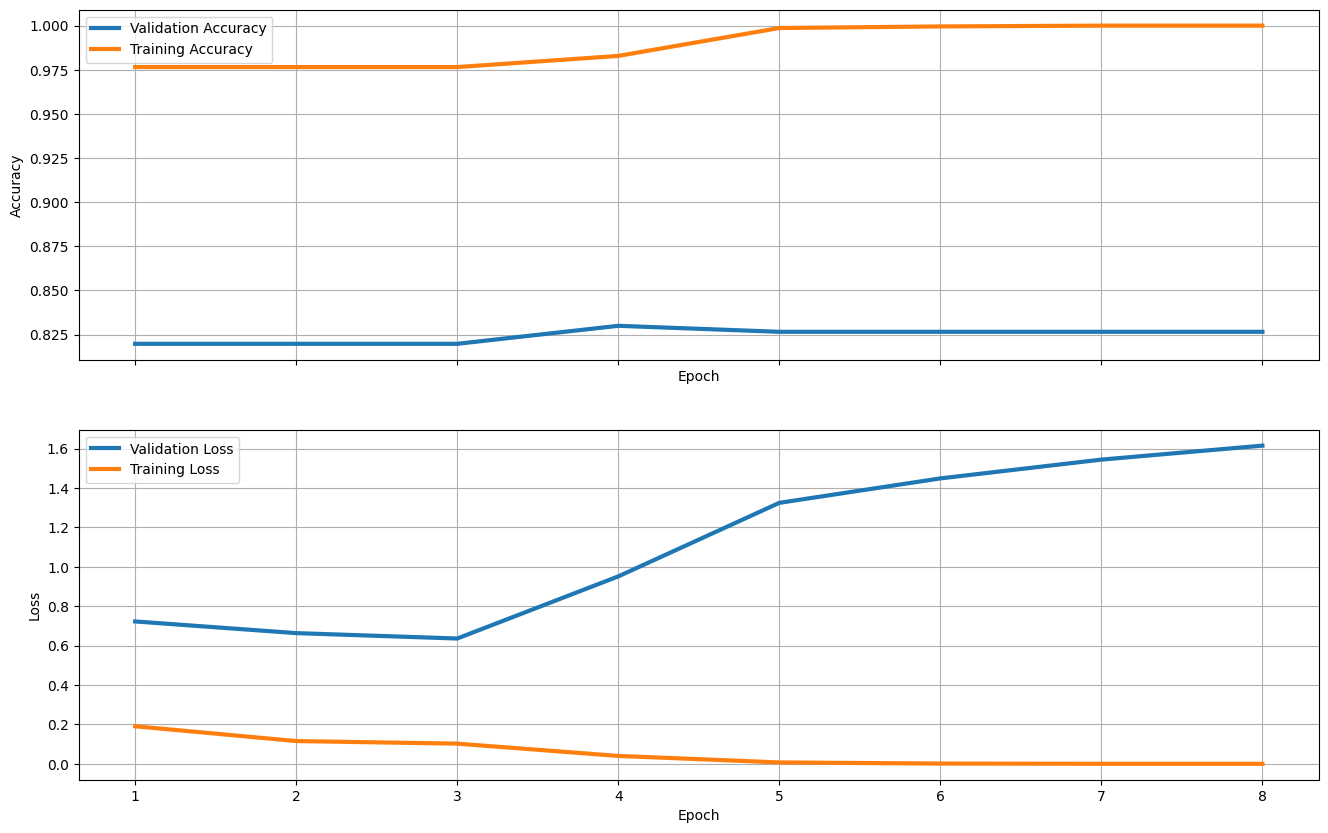

In [136]:
plot_results(history_lstm_real)